# Inference models (TD)

The goal here is to serialize the inference-time version of the two-stage top-down SLEAP models, first into `SavedModel`, and then into TritonRT-optimized engines.

Currently, `SavedModel` serialization doesn't work because our implementation uses `tf.RaggedTensor`s pretty extensively for generalizability.

Here we'll try just getting it working for the test data.

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import system

system.disable_preallocation()
system.summary()

GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
        Initalized: False
     Memory growth: True


In [2]:
def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)

imgs = read_frames("data/190719_090330_wt_18159206_rig1.2@15000-17560.mp4", np.arange(0, 16))
print(imgs.shape, imgs.dtype)

(16, 1024, 1024, 1) uint8


In [3]:
centroid_base_model = tf.keras.models.load_model("data/centroid_sleap_model/best_model.h5", compile=False)
td_base_model = tf.keras.models.load_model("data/td_id_sleap_model/best_model.h5", compile=False)

print("Centroid:", centroid_base_model.inputs, centroid_base_model.outputs)
print("      TD:", td_base_model.inputs, td_base_model.outputs)

Centroid: [<KerasTensor: shape=(None, 512, 512, 1) dtype=float32 (created by layer 'input')>] [<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'CentroidConfmapsHead')>]
      TD: [<KerasTensor: shape=(None, 160, 160, 1) dtype=float32 (created by layer 'input')>] [<KerasTensor: shape=(None, 80, 80, 13) dtype=float32 (created by layer 'CenteredInstanceConfmapsHead')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'ClassVectorsHead')>]


In [4]:
from peak_finding import find_local_peaks, find_global_peaks, make_centered_bboxes, crop_bboxes, describe_tensors


class TopDownInferenceModel(tf.keras.Model):
    def __init__(
        self,
        centroid_base_model,
        centroid_input_size,
        centroid_input_scale,
        centroid_output_stride,
        crop_size,
        td_base_model,
        td_output_stride,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.centroid_base_model = centroid_base_model
        self.centroid_input_size = centroid_input_size
        self.centroid_input_scale = centroid_input_scale
        self.centroid_output_stride = centroid_output_stride
        self.crop_size = crop_size
        self.td_base_model = td_base_model
        self.td_output_stride = td_output_stride
        
    @tf.function
    def stage1(self, imgs):
        """Stage 1: Find centroids"""
        # Preprocessing
        X = tf.cast(imgs, tf.float32) / 255
        X = tf.image.resize(X, self.centroid_input_size)

        # Forward pass
        centroid_cms = self.centroid_base_model(X)

        # Find centroid points for the entire batch
        #     centroids: (n_centroids, 2)
        #     centroid_vals: (n_centroids,)
        #     centroid_sample_inds: (n_centroids,)
        centroids, centroid_vals, centroid_sample_inds, _ = find_local_peaks(centroid_cms, threshold=0.2, refinement="integral")

        # Adjust coordinates for output stride and input scale
        centroids = ((centroids * self.centroid_output_stride) / self.centroid_input_scale) + 0.5

        # TODO: Deal with case where no centroids are found (without resorting to RaggedTensors)

        # Make centered bboxes and crops
        #     bboxes: (n_centroids, 4)
        #     crops: (n_centroids, crop_size, crop_size, channels)
        bboxes = make_centered_bboxes(centroids, self.crop_size, self.crop_size)
        crops = crop_bboxes(imgs, bboxes, centroid_sample_inds)

        # Store crop offsets for coordinate adjustment in stage 2
        #     crop_offsets: (n_centroids, 2)
        crop_offsets = centroids - (self.crop_size / 2)

        return {"crops": crops, "crop_offsets": crop_offsets, "sample_inds": centroid_sample_inds}
    
    @tf.function
    def stage2(self, crops, crop_offsets):
        """Stage 2: Predict pose in each crop"""
        # Preprocessing
        X = tf.cast(crops, tf.float32) / 255

        # Forward pass
        cms, class_probs = self.td_base_model(X)

        # Find keypoints in each crop
        #     pts: (n_centroids, n_nodes, 2)
        #     vals: (n_centroids, n_nodes)
        pts, vals = find_global_peaks(cms, threshold=0.2, refinement="integral")

        # Adjust coordinates for output stride
        pts = pts * self.td_output_stride

        # Adjust for bbox crops
        pts = pts + tf.expand_dims(crop_offsets, axis=1)

        return {"instance_peaks": pts, "instance_peak_vals": vals, "class_probabilities": class_probs}
        
    def call(self, imgs):
        preds1 = self.stage1(imgs)
        preds2 = self.stage2(preds1["crops"], preds1["crop_offsets"])
        preds2["sample_inds"] = preds1["sample_inds"]
        return preds2


td_output_stride = 2
centroid_input_size = [512, 512]
centroid_input_scale = 0.5
centroid_output_stride = 2
crop_size = 160

inference_model = TopDownInferenceModel(
    centroid_base_model,
    centroid_input_size,
    centroid_input_scale,
    centroid_output_stride,
    crop_size,
    td_base_model,
    td_output_stride,
)

imgs = read_frames("data/190719_090330_wt_18159206_rig1.2@15000-17560.mp4", [0, 500, 1500, 2000])
preds = inference_model.predict(imgs)
describe_tensors(preds)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
     instance_peaks: type=ndarray, shape=(8, 13, 2), dtype=float32, device=N/A
 instance_peak_vals: type=ndarray, shape=(8, 13), dtype=float32, device=N/A
class_probabilities: type=ndarray, shape=(8, 2), dtype=float32, device=N/A
        sample_inds: type=ndarray, shape=(8,), dtype=int32, device=N/A


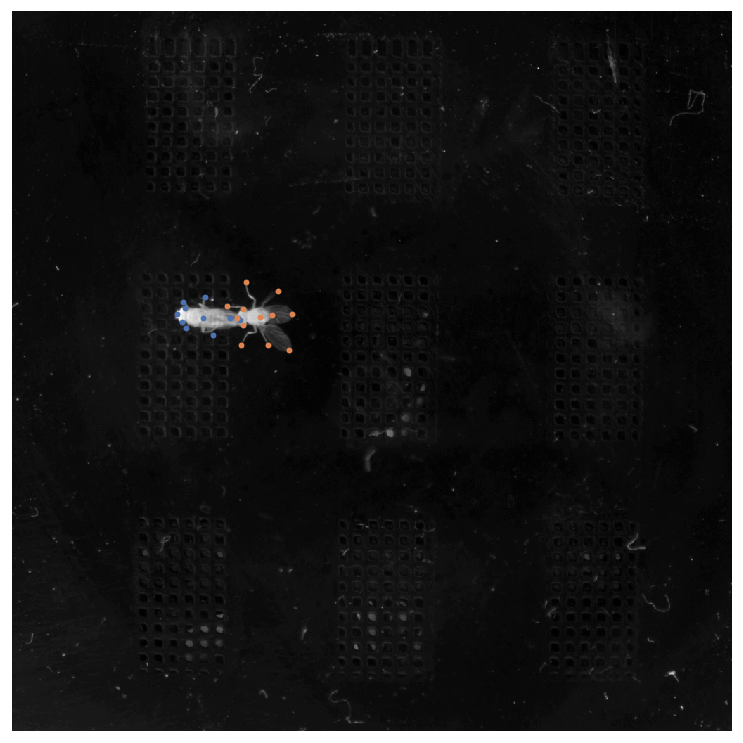

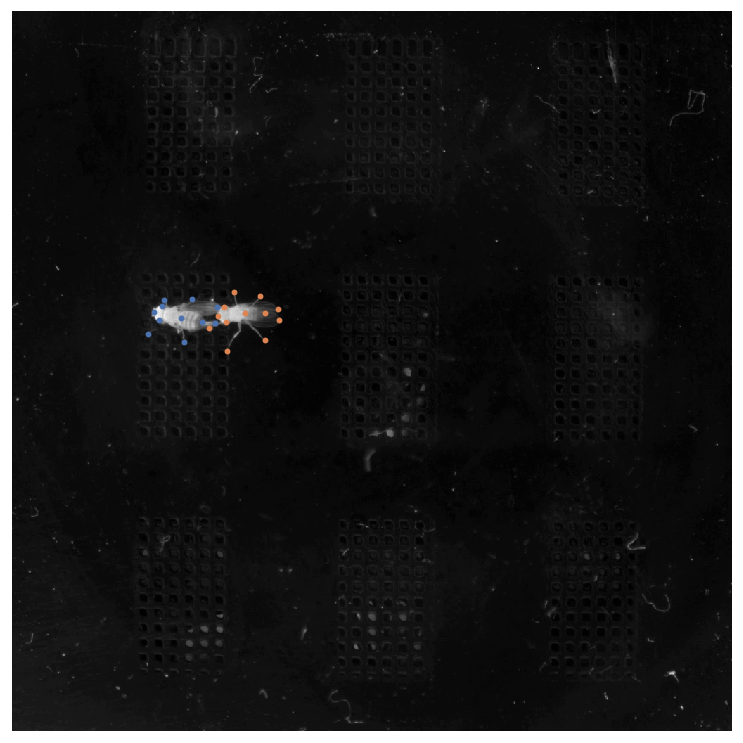

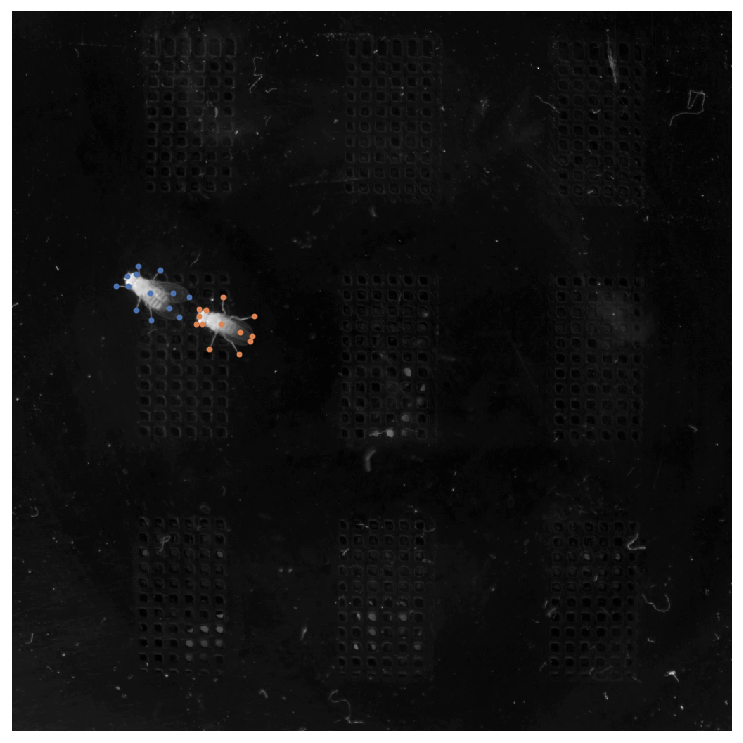

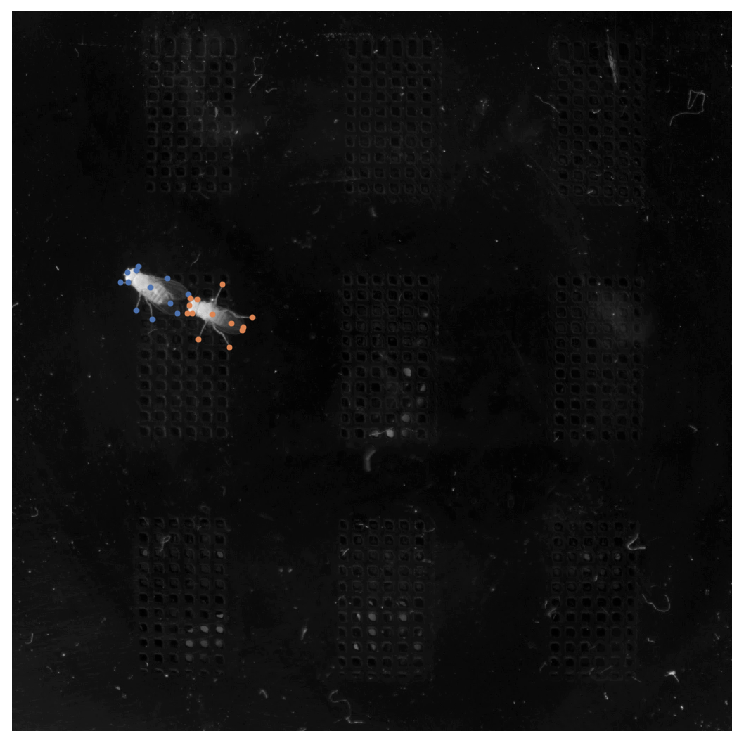

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def imgfig(img):
    """Plot image in a tight figure."""
    fig = plt.figure(figsize=(6, 6), dpi=120)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    h = ax.imshow(img.squeeze(), cmap="gray", origin="upper", interpolation="nearest")
    return fig, h


def plot_preds(imgs, preds, i):
    imgfig(imgs[i])
    poses_i = preds["instance_peaks"][preds["sample_inds"] == i]
    class_probs_i = preds["class_probabilities"][preds["sample_inds"] == i]
    cmap = sns.color_palette("deep")
    for pose, class_probs in zip(poses_i, class_probs_i):
        c = np.argmax(class_probs)
        plt.plot(pose[:, 0], pose[:, 1], ".", ms=5, c=cmap[c])

plot_preds(imgs, preds, 0)
plot_preds(imgs, preds, 1)
plot_preds(imgs, preds, 2)
plot_preds(imgs, preds, 3)

In [6]:
inference_model.save("data/inference_td_id_savedmodel", save_format="tf", save_traces=True)

INFO:tensorflow:Assets written to: data/inference_td_id_savedmodel/assets


In [7]:
def convert_to_trt(saved_model_path, opt_model_path, precision):
    # https://github.com/NVIDIA/TensorRT/blob/master/quickstart/IntroNotebooks/2.%20Using%20the%20Tensorflow%20TensorRT%20Integration.ipynb
    import os
    
    from trtutils import ModelOptimizer
    opt_model = ModelOptimizer(saved_model_path)
    print(f"Created ModelOptimizer with: {saved_model_path}")
    
    import numpy as np
    
    if precision == "INT8":
        import tensorflow as tf
        tf_model = tf.keras.models.load_model(saved_model_path)
        
        # not working:
        # InternalError:  Failed to feed calibration data
        # [[node TRTEngineOp_2_0 (defined at /mnt/helper.py:94) ]] [Op:__inference_pruned_20725]

        # Function call stack:
        # pruned
        N = 32
        calib_data = np.zeros((N,) + tuple(tf_model.inputs[0].shape[1:]))
        print("Set calibration data:", calib_data.shape)
        opt_model.set_calibration_data(calib_data)
    
    opt_model_path_ = f"{opt_model_path}_{precision}"
    opt_model_ = opt_model.convert(opt_model_path_, precision=precision)
    
    if os.path.exists(opt_model_path_):
        print(f"Converted model: {opt_model_path_}")
        return True
    else:
        print(f"Failed to convert model: {opt_model_path_}")
        return False
    
    
convert_to_trt("data/inference_td_id_savedmodel", "data/inference_td_id_trt", precision="FP32")
convert_to_trt("data/inference_td_id_savedmodel", "data/inference_td_id_trt", precision="FP16")

Created ModelOptimizer with: data/inference_td_id_savedmodel
INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 3)
INFO:tensorflow:Loaded TensorRT 7.2.3 and linked TensorFlow against TensorRT 7.2.2. This is supported because TensorRT  minor/patch upgrades are backward compatible
INFO:tensorflow:Could not find TRTEngineOp_0_9 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_7 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_8 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_6 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cac

True